In [1]:
#import numpy as np
#import pandas as pd
##scrambles the OA->MSOA
#df = pd.read_csv('oa_to_lsoa/OA11_LSOA11_MSOA11_LAD11_EW_LUv2.csv',encoding='latin-1')
#df['MSOA11CD'] = np.random.randint(1,50,df.shape[0])
#df.to_csv('oa_to_lsoa/RANDOM_SOAS_2.csv')

# Integral Model

In [1]:
import paper_tools
import census
import numpy as np
#load the census data

def unnormalise_mean(normY, normparams):
    return (normY*normparams['std'])#+normparams['mean'])

def unnormalise_var(normvar, normparams):
    return (normvar*normparams['std']**2)

def normalise(Y):
    mean = np.mean(Y)
    std = np.std(Y)
    normparams = {'mean':mean, 'std':std}
    normY = (Y)/std
    return normY, normparams

#cardiff
#bbox = [328,335,184,193]
#sheffield
#bbox = np.array([430,440,381,391])
bbox = np.array([433,437,384,388])
shapefilename='oaboundaries/Output_Area_December_2011_Generalised_Clipped_Boundaries_in_England_and_Wales.shp'
oafilename='oa_to_lsoa/OA11_LSOA11_MSOA11_LAD11_EW_LUv2.csv'
randomoafilename = 'oa_to_lsoa/RANDOM_SOAS_2.csv' #this file contains MSOA that have been randomly assigned
oadescfilename='oadata/KS102ew_2011_oa/KS102EW_2011STATH_NAT_OA_REL_1.4.4/KS102EWDESC0.CSV'
oadatafilename='oadata/KS102ew_2011_oa/KS102EWDATA.CSV'

#X,Y,testX,testY = census.get_census_data(box=bbox*1000,verbose=True)
X,Y,testX,testY = census.get_census_data(shapefilename=shapefilename,
                                         oafilename=randomoafilename,
                                         oadescfilename=oadescfilename,
                                         oadatafilename=oadatafilename,
                                         box=bbox*1000,verbose=True,refresh=False)

normY,normparams = normalise(Y)

def getsolution(ls,var,noise,Nperunit=25):
    #print("Building Model")
    m = paper_tools.build_integral_model(X,normY,testX,Nperunit=Nperunit, lengthscale=ls)
    m.kern.kernel.variance.fix(var)
    m.Gaussian_noise = noise
    #m.optimize(messages=True) #TODO probably should crank up Nperunit to do this?
    norm_pred_int,norm_predvar_int=m.predict(testX)
    pred_int = unnormalise_mean(norm_pred_int,normparams)
    predvar_int = unnormalise_var(norm_predvar_int, normparams)

    #paper_tools.print_predictions(pred_int, predvar_int, testY, testX)
    return m, pred_int, paper_tools.get_rmse(testX,testY,pred_int), paper_tools.get_meanabserror(testX,testY,pred_int)
    #print("RMSE")
    #print(paper_tools.get_rmse(testX,testY,pred_int))
    #print("Mean Abs Error")
    #print(paper_tools.get_meanabserror(testX,testY,pred_int))

Trying cache...
Cache loaded.
Loaded from cache, 49 training polygons and 358 testing polygons


In [2]:
#This cell is to produce equivalent rectangle-approximation results
from shapeintegrals_fast_hypercubes import ShapeIntegralHC as IntegralHC
import GPy

def build_integralHC_model(X,Y,testX,Nperunit=20, lengthscale=0.16, variance=50.0):
    """Builds integral model"""
    k = IntegralHC(X.shape[1],input_space_dim=2,Nrecs=Nperunit,variances=np.array(variance), lengthscale=np.array([lengthscale,lengthscale]))
    m = GPy.models.GPRegression(X,Y,k,normalizer=False)
    m.Gaussian_noise = 1
    #m.kern.lengthscale.fix(lengthscale)
    m.kern.kernel.lengthscale.fix(lengthscale)
    return m

def getsolutionHC(ls,var,noise,Nperunit=25):
    #print("Building Model")
    m = build_integralHC_model(X,normY,testX,Nperunit=Nperunit, lengthscale=ls, variance=var)
    #m.kern.kernel.variance.fix(var)
    m.Gaussian_noise = noise
    #m.optimize(messages=True) #TODO probably should crank up Nperunit to do this?
    norm_pred_int,norm_predvar_int=m.predict(testX)
    pred_int = unnormalise_mean(norm_pred_int,normparams)
    predvar_int = unnormalise_var(norm_predvar_int, normparams)

    #paper_tools.print_predictions(pred_int, predvar_int, testY, testX)
    return m, pred_int, paper_tools.get_rmse(testX,testY,pred_int), paper_tools.get_meanabserror(testX,testY,pred_int)
    #print("RMSE")
    #print(paper_tools.get_rmse(testX,testY,pred_int))
    #print("Mean Abs Error")
    #print(paper_tools.get_meanabserror(testX,testY,pred_int))

In [6]:

for nou in [5,10,20,40,80,160]:
    rmses = []
    maes = []
    for it in range(20):
        m, pred_int, rmse, mae = getsolution(0.05,20,1e-6,Nperunit=nou)
        rmses.append(rmse)
        maes.append(mae)
    print(nou,np.mean(rmses),np.std(rmses)/np.sqrt(len(rmses)),np.mean(maes),np.std(maes)/np.sqrt(len(maes)))

 /home/mike/Documents/Research/SheffieldMLpublications/publications/integralkernel/jupyter/shapeintegrals_fast.py:77: RuntimeWarning:divide by zero encountered in true_divide


KeyboardInterrupt: 

#simple model (for comparison): 15817.7392083 5394.52343756

Number of training points per unit space
5 16166.7359116 6130.87705005
10 15409.0455252 5717.87359218
20 14376.6586168 5147.52881257
40 13284.5954905 4472.34036072
80 13737.4169867 4286.6928576
160 14957.6146994 4286.15521089

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
#m = paper_tools.build_integral_model(X,normY,testX,Nperunit=10, lengthscale=10)
temppoints,_ = m.kern.placepoints(X[0],Nperunit=16000)

points,_ = m.kern.placepoints(X[0],Nperunit=160)

#print(totvol,totvolcheck)
plt.figure(figsize=[8,8])
plt.scatter(temppoints[:,0],temppoints[:,1],1,c=(0.9,0.9,0.9))
plt.scatter(points[:,0],points[:,1],1)

for i in [1]:
    checkpoints,_ = m.kern.placepoints(X[0],Nperunit=5)
    print(len(checkpoints))
    plt.scatter(checkpoints[:,0],checkpoints[:,1],20)
plt.savefig('pointplacement.pdf')

NameError: name 'm' is not defined

# Simple model

In [3]:
import paper_tools
import census
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#load the census data

#cardiff
#bbox = [328,335,184,193]
#sheffield
#bbox = np.array([430,440,381,391])
#bbox = np.array([433,437,384,388])
#X,Y,testX,testY = census.get_census_data(box=bbox*1000,verbose=True)
#X,Y,testX,testY = census.get_census_data(shapefilename=shapefilename,oafilename=randomoafilename,oadescfilename=oadescfilename,oadatafilename=oadatafilename,box=bbox*1000,verbose=True,refresh=False)
normY,normparams = normalise(Y)
print("Building Model")

def get_simple_solution(ls,var,noise):
    m = paper_tools.build_simple_model(X,normY,testX, lengthscale=ls)
    m.kern.variance.fix(var)
    m.Gaussian_noise = noise
    #m.kern.lengthscale.unfix()
    
    #m.optimize(messages=True)
    centroidtestX, test_areas = paper_tools.compute_centroids_and_areas(testX)
    norm_density_pred,normpredvar=m.predict(centroidtestX)
    norm_pred=norm_density_pred*test_areas
    norm_predvar=normpredvar*test_areas**2 #todo - is this right?
    pred = unnormalise_mean(norm_pred,normparams)
    predvar = unnormalise_var(norm_predvar, normparams)

    #paper_tools.print_predictions(pred, predvar, testY, testX)    
    return m, pred, paper_tools.get_rmse(testX,testY,pred), paper_tools.get_meanabserror(testX,testY,pred)


Building Model


In [5]:
m,pred,simple_rmse, simple_mae = get_simple_solution(0.5,12.7,1e-6)
#m, pred_int_hc, rmse, mae = getsolutionHC(0.05,20,1e-6,Nperunit=40)
m, pred_int, rmse, mae = getsolution(0.05,20,1e-6,Nperunit=40)
centroidtestX, test_areas = paper_tools.compute_centroids_and_areas(testX)

 /home/mike/Documents/Research/SheffieldMLpublications/publications/integralkernel/jupyter/shapeintegrals_fast.py:77: RuntimeWarning:divide by zero encountered in true_divide


In [17]:
len(testX)

358

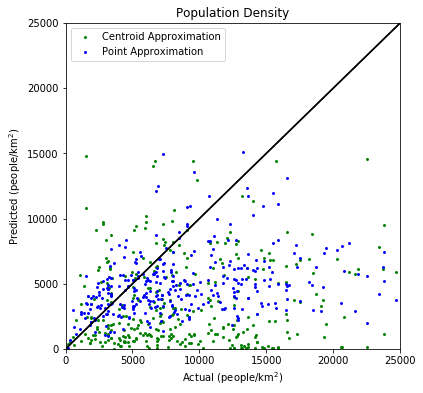

In [16]:
plt.figure(figsize=[6,6])
paper_tools.plot_results_comparison(testX,testY,pred,15,'.','g',label='Centroid Approximation')
paper_tools.plot_results_comparison(testX,testY,pred_int,15,'.','b',label='Point Approximation')
#paper_tools.plot_results_comparison(testX,testY,pred_int_hc,15,'.','r',label='Rectangle Approximation')
 
plt.legend()

plt.xlim([0,25000])
plt.ylim([0,25000])
plt.savefig('results_comparison.pdf')

In [ ]:
simple_rmses = []
simple_maes = []
for it in range(20):
    m,pred,simple_rmse, simple_mae = get_simple_solution(0.5,12.7,1e-6)
    #m,pred,simple_rmse, simple_mae = get_simple_solution(1,20,1e-6)
    simple_rmses.append(simple_rmse)
    simple_maes.append(simple_mae)
print(np.mean(simple_rmses), np.std(simple_rmses)/np.sqrt(len(simple_rmses)))
print(np.mean(simple_maes), np.std(simple_maes)/np.sqrt(len(simple_maes)))

In [ ]:
rmses = []
maes = []
for it in range(20):
    m, pred_int, rmse, mae = getsolution(0.05,20,1e-6,Nperunit=40)
    rmses.append(rmse)
    maes.append(mae)

In [ ]:
paper_tools.plot_results_comparison(testX,testY,pred_int)
paper_tools.plot_results_comparison(testX,testY,pred)


In [14]:
print("\\begin{tabular}{l r r}")
print("\\hline")
print("Method & \multicolumn{2}{c}{Method} \\\\")
print(" & Integral & Centroid \\\\")
print("\\hline")
print("RMSE & %0.1f & %0.1f\\\\" % (rmse,simple_rmse))
print("MAE & %0.1f & %0.1f\\\\" % (mae,simple_mae))
print("\\hline")    
print("\\end{tabular}")

\begin{tabular}{l r r}
\hline
Method & \multicolumn{2}{c}{Method} \\
 & Integral & Centroid \\
\hline
RMSE & 12863.7 & 17038.2\\
MAE & 3910.7 & 5282.5\\
\hline
\end{tabular}
